<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura: Machine learning 2: Unsupervised learning</center>


# Challenge S5: Clusterización II

## Plan de expansión: apertura de nuevas tiendas

Una cadena de supermercados desea identificar áreas en las que abrir nuevos centros.

Utilizando información censal (tabla CENSUS2000) el objetivo es encontrar áreas cuyos perfiles de clientes se adapten a diferentes tipologías de centros: boutiques, supermercados de presupuesto medio, grandes superficies, etc.

Se supone que el país tiene una densidad muy baja de establecimientos comerciales y se puede seguir abriendo tiendas en las diferentes regiones.

<img src="tienda.jpg">

## Configuración del entorno

Es recomendable declarar en un bloque al inicio todos los paquetes que vas a utilizar en este notebook:

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

### Información del dataset Census2000
Como hemos mencionado, vamos a hacer uso de un dataset con información censal (tabla CENSUS2000).

Las variables de las que dispone son:  

* Numrow: Numero de fila
* ID: Identificador del registro
* LocX y LocY para geolocalizar las zonas
* RegDens: Densidad de población de la región
* RegPop: Número de habitantes de la región
* MedHHInc: Nivel de ingresos medio de la unidad familiar
* MeanHHSz: Tamaño medio de la unidad familiar (HH = Household)

Los datos se encuentran en un fichero `csv` llamado `census2000.csv`.

Carga los datos en un dataframe para hacer los ejercicios de este bloque.

In [2]:
dfc=pd.read_csv("census2000.csv")

Una vez cargados los datos debemos inspeccionarlos antes de empezar nuestro análisis.

In [3]:
dfc.head()

Numrow     ID       LocX       LocY  RegDens   RegPop  MedHHInc  MeanHHSz
0       0  00601 -66.749472  18.180103     70.0  19143.0    9888.0      3.24
1       1  00602 -67.180247  18.363285     83.0  42042.0   11384.0      3.10
2       2  00603 -67.134224  18.448619     86.0  55592.0   10748.0      2.84
3       3  00604 -67.136995  18.498987     83.0   3844.0   31199.0      3.00
4       4  00606 -66.958807  18.182151     65.0   6449.0    9243.0      3.20

¿Cuantos registros y columnas tiene el dataset?

¿De que tipo son los datos cargados?

El dataset cuenta con 8 columnas y 33178 registros.
Los datos cargados son en su mayoría de tipo float, aunqeu también hay tipo object e int.

In [4]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 8 columns):
Numrow      33178 non-null int64
ID          33178 non-null object
LocX        33178 non-null float64
LocY        33178 non-null float64
RegDens     32165 non-null float64
RegPop      33178 non-null float64
MedHHInc    33178 non-null float64
MeanHHSz    33178 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.0+ MB


## Filtrado de datos
Una particularidad de este dataset es que contiene información sobre hogares que no tiene miembros en la unidad familiar. Cuantos registros se tienen con unidades familiares iguales o superiores a 1?:

In [5]:
dfc_m1 = dfc[dfc['MeanHHSz'] >= 1]

In [6]:
dfc_m1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32079 entries, 0 to 33177
Data columns (total 8 columns):
Numrow      32079 non-null int64
ID          32079 non-null object
LocX        32079 non-null float64
LocY        32079 non-null float64
RegDens     32079 non-null float64
RegPop      32079 non-null float64
MedHHInc    32079 non-null float64
MeanHHSz    32079 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.2+ MB


En este caso vamos a trabajar sólo con aquellos registros con unidades familiares mayores o iguales que 2, para ello tienes que filtrar los datos y quedarte solo con dichos datos.

In [7]:
dfc2 = dfc[dfc['MeanHHSz'] >= 2]
dfc2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30899 entries, 0 to 33177
Data columns (total 8 columns):
Numrow      30899 non-null int64
ID          30899 non-null object
LocX        30899 non-null float64
LocY        30899 non-null float64
RegDens     30899 non-null float64
RegPop      30899 non-null float64
MedHHInc    30899 non-null float64
MeanHHSz    30899 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.1+ MB


De esta manera hemos filtrado los datos y podemos ver el resultado:

In [8]:
dfc2.head()

Numrow     ID       LocX       LocY  RegDens   RegPop  MedHHInc  MeanHHSz
0       0  00601 -66.749472  18.180103     70.0  19143.0    9888.0      3.24
1       1  00602 -67.180247  18.363285     83.0  42042.0   11384.0      3.10
2       2  00603 -67.134224  18.448619     86.0  55592.0   10748.0      2.84
3       3  00604 -67.136995  18.498987     83.0   3844.0   31199.0      3.00
4       4  00606 -66.958807  18.182151     65.0   6449.0    9243.0      3.20

## Visualización de los datos
Para hacernos una idea de los datos podemos generar algunos gráficos con las principales características de los datos. Podemos utilizar gráficos de barras, sectores, histograma de frecuencias.

(array([1.9008e+04, 1.0610e+04, 1.0080e+03, 2.1200e+02, 4.7000e+01,
        7.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([2.        , 2.649     , 3.298     , 3.94699999, 4.59599999,
        5.24499999, 5.89399999, 6.54299999, 7.19199998, 7.84099998,
        8.48999998]),
 <a list of 10 Patch objects>)

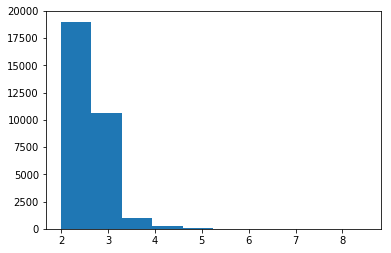

In [9]:
plt.hist(dfc2['MeanHHSz'], bins=None)

(array([1.9150e+03, 1.8935e+04, 7.5270e+03, 1.7800e+03, 5.0100e+02,
        1.5800e+02, 4.7000e+01, 2.4000e+01, 5.0000e+00, 7.0000e+00]),
 array([  2499. ,  22249.2,  41999.4,  61749.6,  81499.8, 101250. ,
        121000.2, 140750.4, 160500.6, 180250.8, 200001. ]),
 <a list of 10 Patch objects>)

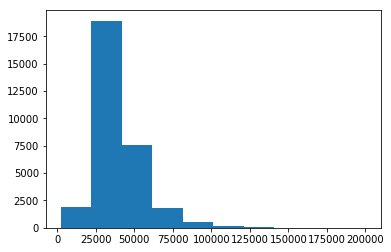

In [10]:
plt.hist(dfc2['MedHHInc'], bins=None)

(array([2922., 3156., 3162., 3189., 3164., 3171., 3141., 3083., 3055.,
        2856.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <a list of 10 Patch objects>)

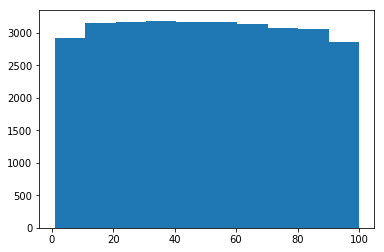

In [11]:
plt.hist(dfc2['RegDens'], bins=None)

(array([2.4128e+04, 3.8620e+03, 1.9420e+03, 6.8500e+02, 1.7700e+02,
        6.7000e+01, 2.8000e+01, 9.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.00000e+00, 1.44060e+04, 2.88080e+04, 4.32100e+04, 5.76120e+04,
        7.20140e+04, 8.64160e+04, 1.00818e+05, 1.15220e+05, 1.29622e+05,
        1.44024e+05]),
 <a list of 10 Patch objects>)

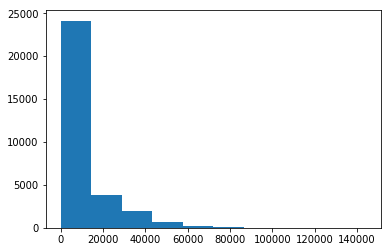

In [12]:
plt.hist(dfc2['RegPop'], bins=None)

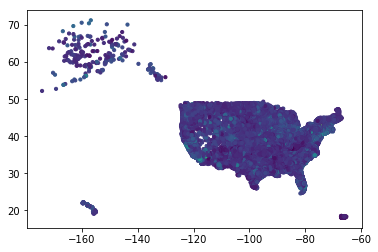

In [13]:
plt.scatter(dfc2['LocX'], dfc2['LocY'], c=dfc2['MedHHInc'], s=10)

* ¿Qué nos están diciendo estos gráficos sobre los datos?
* ¿Aprecias normalidad de los datos? Genera un histograma con cada variable que consideres y revisa si ¿Tiene forma de campana?

También puedes revisar la relación que existe entre las variables, la forma mas sencilla es mediante un gráfico de dispersión o calculando el coeficiente de correlación para revisar las relaciones lineales.

#### Algunos apuntes sobre el coeficiente de correlación
El [coeficiente de correlación ](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson) es una medida del grado de *dependencia lineal* entre dos variables. El [coeficiente de correlación](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson) oscila entre -1 y 1. Un valor de 1 significa que una [ecuación lineal](https://es.wikipedia.org/wiki/Ecuaci%C3%B3n_de_primer_grado) describe la relación entre las dos variables a la perfección, con todos los puntos de datos cayendo sobre una línea recta de pendiente positiva. Un valor de -1 implica que todos los puntos de datos se encuentran en una línea con pendiente negativa. Un valor de 0 implica que no existe una correlación lineal entre las variables. Lo podemos calcular con el método `corr`.

In [14]:
# coeficiente de correlación
dfc.corr()

Numrow      LocX      LocY   RegDens    RegPop  MedHHInc  MeanHHSz
Numrow    1.000000 -0.890211 -0.040698 -0.279206  0.000452 -0.095748  0.081048
LocX     -0.890211  1.000000 -0.117027  0.253760 -0.012464  0.059968 -0.095487
LocY     -0.040698 -0.117027  1.000000 -0.162222 -0.172125  0.107797 -0.020887
RegDens  -0.279206  0.253760 -0.162222  1.000000  0.610728  0.346848  0.042379
RegPop    0.000452 -0.012464 -0.172125  0.610728  1.000000  0.233125  0.167188
MedHHInc -0.095748  0.059968  0.107797  0.346848  0.233125  1.000000  0.401540
MeanHHSz  0.081048 -0.095487 -0.020887  0.042379  0.167188  0.401540  1.000000

#### Recuerda también que correlación no implica causalidad.
Todo esto de la mala interpretación de la correlación también se encuentra, y en demasiadas ocasiones, en estudios científicos supuestamente serios. No son pocos los estudios que al encontrar una cierta relación entre dos variables presentes en los sujetos estudiados se tiran a la piscina afirmando que por tanto una de ellas es la causa de la otra, cuando en realidad en dichos estudios no hay ninguna evidencia de que esto sea verdad (simplemente hay correlación).

Echa un vistazo a este link y sorprendete con las "Spurious correlations"  http://tylervigen.com/spurious-correlations

<img src="correlacion.png" style="height: 150px">

## Transformación de variables

Una herramienta muy interesante a utilizar en aquellas variables que no cumplan con los criterios de normalidad es aplicar alguna transformación sobre las mismas, en particular el logaritmo funciona muy bien, y después de aplicarla confirma si los datos transformados se comportan como una normal.

Las ventajas de aplicar una transformación cuando la distribución de la variable no es normal son las siguientes:

* Que el efecto de posibles outliers sea menor.
* En algunos casos podría inducir normalidad, condición no necesaria, pero deseable.
* Que los rangos de las variables sean más comparables

<img src="logaritmo.png" style="height: 200px">

(array([4.4040e+03, 1.5909e+04, 8.3680e+03, 1.5180e+03, 5.1500e+02,
        1.5000e+02, 2.5000e+01, 4.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([0.69314718, 0.83772136, 0.98229554, 1.12686973, 1.27144391,
        1.41601809, 1.56059227, 1.70516645, 1.84974063, 1.99431482,
        2.138889  ]),
 <a list of 10 Patch objects>)

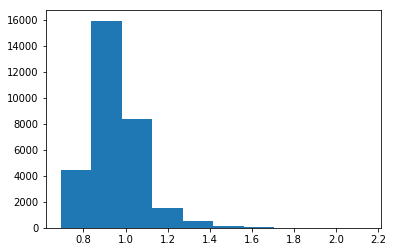

In [15]:
dfc2['MeanHHSz'] = np.log(dfc2['MeanHHSz'])
plt.hist(dfc2['MeanHHSz'], bins=None)

(array([  13.,  112.,  598., 2150., 4481., 6438., 6123., 5258., 5205.,
         521.]),
 array([ 1.38629436,  2.43543845,  3.48458254,  4.53372662,  5.58287071,
         6.6320148 ,  7.68115888,  8.73030297,  9.77944706, 10.82859114,
        11.87773523]),
 <a list of 10 Patch objects>)

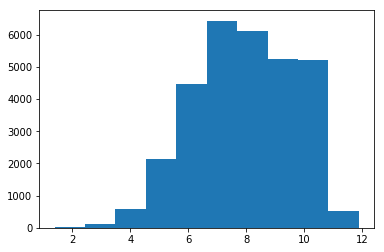

In [16]:
dfc2['RegPop'] = np.log(dfc2['RegPop'])
plt.hist(dfc2['RegPop'], bins=None)

## Tratamiento de los datos, preprocessing

Respecto al tratamiento de datos, se llevarán a cabo las siguientes tareas:

* Imputación de missings.- la única variable que contiene valores missings es RegDens. Se predecirán sus valores a partir del resto de explicativas.

* Tratamiento de outliers.- se podrían filtras aquellas observaciones atípicas respecto de cada una de las variables. Hay que tener en cuenta que esto implicaría la pérdida de algunas regiones. 

* Alternativamente (para no perder registros) o de forma adicional, se puede aplicar una transformación a las variables con las ventajas ya mencionadas

Como podemos observar, no hay ningún valor nulo.

In [17]:
dfc2['MedHHInc'].isnull().values.any()

False

In [18]:
dfc2['RegDens'].isnull().values.any()

False

In [19]:
dfc2['RegPop'].isnull().values.any()

False

In [20]:
dfc2['MeanHHSz'].isnull().values.any()

False

Buscamos outliers

In [21]:
dfc2['RegDens'].describe()

count    30899.000000
mean        50.202207
std         28.414435
min          1.000000
25%         26.000000
50%         50.000000
75%         75.000000
max        100.000000
Name: RegDens, dtype: float64

In [22]:
dfc2['RegPop'].describe()

count    30899.000000
mean         7.946995
std          1.720831
min          1.386294
25%          6.700731
50%          7.940228
75%          9.388738
max         11.877735
Name: RegPop, dtype: float64

In [23]:
dfc2['MedHHInc'].describe()

count     30899.000000
mean      39682.335286
std       15938.201292
min        2499.000000
25%       29931.000000
50%       36250.000000
75%       45686.000000
max      200001.000000
Name: MedHHInc, dtype: float64

In [24]:
dfc2[dfc2['MedHHInc'] > 200000].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 5981 to 31007
Data columns (total 8 columns):
Numrow      4 non-null int64
ID          4 non-null object
LocX        4 non-null float64
LocY        4 non-null float64
RegDens     4 non-null float64
RegPop      4 non-null float64
MedHHInc    4 non-null float64
MeanHHSz    4 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 288.0+ bytes


Se observan cuatro valores por encima del máximo (posible outlier), por lo que lo trataremos como valor normal.

In [25]:
dfc2['MeanHHSz'].describe()

count    30899.000000
mean         0.954530
std          0.122693
min          0.693147
25%          0.879627
50%          0.943906
75%          1.015231
max          2.138889
Name: MeanHHSz, dtype: float64

## Imputación de valores ausentes
En los pasos anteriores hemos identificado los outliers y les hemos asignado a un valor nulo.

Ahora en este paso lo que vamos a hacer es darles un valor a los outliers para tener un dataset sin valores nulos y completar también si hay datos missing. Utiliza la técnica que consideres mas adecuada.

Recuerda que una opción es predecir los valores missing a partir de otras variables explicativas a través de una regresión.

Para mostrarte como realizar una regresión simple te incluyo un ejemplo a continuación.
En primer lugar generamos unos datos "casi aleatorios" que nos sirvan de ejemplo. Se trata de ajustar una línea que siga el modelo siguiente:
$$
y = ax + b
$$
donde $a$ es conocida como *slope* o *pendiente*, y $b$ es conocida como *intercept* o *constante*.

Consideramos los siguientes datos, que mostramos con gráfico de dispersión y que consiste en un modelo con pendiente 2 y constante -5:

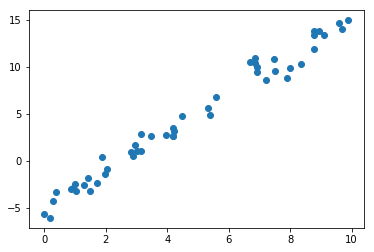

In [26]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

Podemos utilizar el estimador Scikit-Learn's LinearRegression para ajustar los datos y construir la recta que mejor se ajusta:

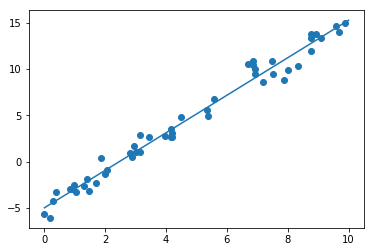

In [27]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Y ya lo tenemos, la pendiente y la constante del modelo están en los parámetros fit, que como sabemos aparecen en Scikit-Learn marcados con un guión bajo.
Los parámetros relevantes son ``coef_`` y ``intercept_``. Y podemos utilizar cualquier nuevo dato de x para estimar y.

* ¿Consideras que dispones ahora de un dataset mas adecuado para hacer un clustering? ¿Por qué?

Si


# Clustering jerárquico aglomerativo y kmeans

En esta parte queremos aplicar el método K-means ( y en particular kmeans ++) al dataset anterior con el objetivo de determinar los clusters mas adecuados para abrir tiendas e incluso la tipología de tiendas que consideremos mas apropiada para los diferentes clusters.

* Aunque existen otras técnicas, se recomienda aplicar un método de clusterización jerárquico aglomerativo en una primera etapa y a través del dendrograma seleccionar el número de clusters adecuado

* Posteriormente aplicamos kmeans sobre los clusters estimados por el metodo jerárquico.

<img src="dendrograma.png" width="50%">

Para que sea mas productivo, la recomendación es realizarlo de la siguiente forma:

* Primero seleccionar una submuestra de 100-200 registros para visualizar adecuadamente el dendrograma y de ahí extraer el número de clusters.
* Aplicar kmeans al número de clusters elegido previamente.

Si el resultado no fuese adecuado ejecutar kmeans variando el número de clusters de acuerdo a la información proporcionada por el dendrograma.

In [28]:
dfc2 = dfc2[['LocX', 'LocY', 'RegDens', 'RegPop', 'MedHHInc', 'MeanHHSz']].values

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(dfc2)
print(kmeans.cluster_centers_)
y_km = kmeans.fit_predict(dfc2)

[[-9.11693557e+01  3.93462206e+01  4.54501098e+01  7.85053433e+00
   3.61997310e+04  9.42776807e-01]
 [-8.87560834e+01  3.94103926e+01  7.49088063e+01  9.02530383e+00
   6.88727237e+04  1.00449978e+00]
 [-9.04654675e+01  3.97152493e+01  6.09788468e+01  8.42910096e+00
   4.92945161e+04  9.73660033e-01]
 [-8.70585789e+01  3.90267055e+01  7.84610895e+01  8.78330360e+00
   1.06498914e+05  1.03825551e+00]
 [-9.20242430e+01  3.73742613e+01  4.03347126e+01  7.36859859e+00
   2.52140752e+04  9.38097224e-01]]


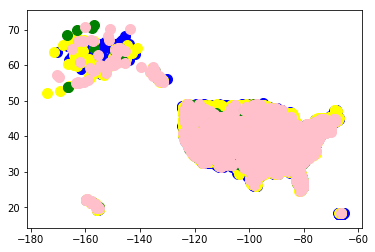

In [30]:
plt.scatter(dfc2[y_km ==1,0], dfc2[y_km == 1,1], s=100, c='blue')
plt.scatter(dfc2[y_km ==2,0], dfc2[y_km == 2,1], s=100, c='cyan')
plt.scatter(dfc2[y_km ==3,0], dfc2[y_km == 3,1], s=100, c='yellow')
plt.scatter(dfc2[y_km ==4,0], dfc2[y_km == 4,1], s=100, c='green')
plt.scatter(dfc2[y_km ==0,0], dfc2[y_km == 0,1], s=100, c='pink')

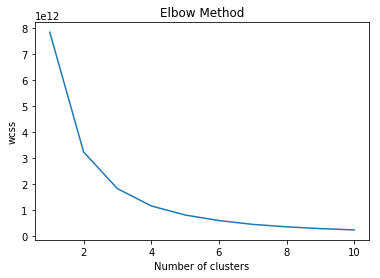

In [31]:
#Usamos el método Elbow para averiguar el número de clusters óptimo
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(dfc2)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

Como podemos observar, a partir de 5/6 clusters no mejora el resultado. Por tanto, he elegido 5 clusters para este ejercicio.

# ¿Y si utilizas DBSCAN?

Text(0, 0.5, 'Feature 1')

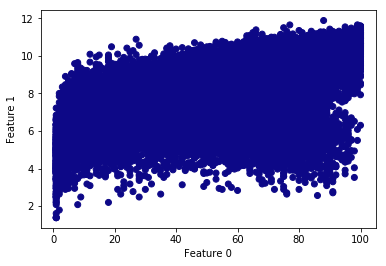

In [32]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

dbscan = DBSCAN(eps=1.5, min_samples = 10)
clusters = dbscan.fit_predict(dfc2)

plt.scatter(dfc2[:, 2], dfc2[:, 3], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# Perfiles de los clusters (profiling)

Una vez generados los clusters adecuados tenemos que analizar el pérfil de cada uno de los segmentos, utilizando las variables que tenemos disponibles.

El análisis de los pérfiles nos ayudará a establecer las conclusiones y las recomendaciones.

In [33]:
Perfiles = pd.DataFrame(dfc2, columns=['LocX', 'LocY', 'RegDens','RegPop', 'MedHHInc', 'MeanHHSz'])
Perfiles['Perfil'] = y_km

Perfiles = Perfiles[['RegDens','RegPop', 'MedHHInc', 'MeanHHSz', 'Perfil']]
Perfiles = Perfiles.groupby(['Perfil']).mean().add_suffix('_avg').reset_index()

In [34]:
Perfiles

Perfil  RegDens_avg  RegPop_avg   MedHHInc_avg  MeanHHSz_avg
0       0    60.838568    8.421453   49153.967337      0.973127
1       1    40.337006    7.369950   25221.625918      0.938072
2       2    78.190227    8.789352  104501.017452      1.037810
3       3    45.439987    7.850635   36180.877138      0.942734
4       4    74.685569    9.020878   68213.913180      1.004163

# Conclusiones y recomendaciones

* ¿Cuantos clusters has identificado?
* ¿Qué les caracteriza a cada uno de ellos?

Se han identificado 5 clusters. Podemos observar que los Perfiles 2 y 4 son bastante parecidos. Ambos tienen un nivel de ingresos medio alto y viven en zonas altamente pobladas y alta densidad de población (grandes ciudades).
Para el cluster 0, tenemos también un perfil de personas que viven en grandes ciudades pero con un nivel de ingresos menor.
Por último, los perfiles 1 y 3 se tratan de zonas con poca densidad de población y nivel de ingresos bajo - zonas más rurales.

##### Grandes ciudades + altos ingresos

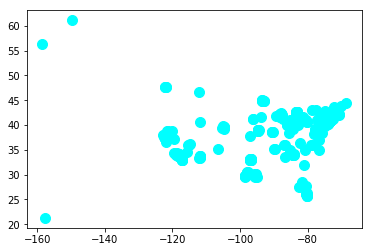

In [40]:
plt.scatter(dfc2[y_km ==2,0], dfc2[y_km == 2,1], s=100, c='cyan')

In [41]:
plt.scatter(dfc2[y_km ==4,0], dfc2[y_km == 4,1], s=100, c='pink')

Se observa que en el caso del cluster 2, que es el que mayor ingresos presenta, se trata de las grandes ciudades y centros financieros de USA.

##### Grandes ciudades + ingresos medios

In [46]:
plt.scatter(dfc2[y_km == 0,0], dfc2[y_km == 0,1], s=100, c='blue')

##### Zonas rurales + bajos ingresos

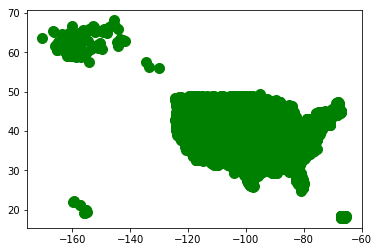

In [45]:
plt.scatter(dfc2[y_km == 1,0], dfc2[y_km == 1,1], s=100, c='green')

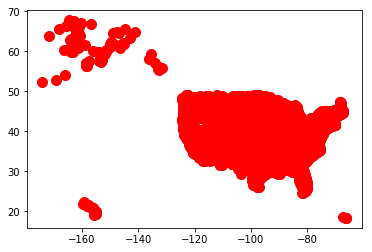

In [44]:
plt.scatter(dfc2[y_km == 3,0], dfc2[y_km == 3,1], s=100, c='red')

* ¿Qué propuesta de tipología de tiendas propondrías?

###### Grandes ciudades y altos ingresos 
Propondría tiendas tipo boutique en la que estas personas pudieran comprar artículos de importación y ecológicos, ya que el nivel de ingresos medio es alto y se gastarían más dinero en este tipo de productos más exclusivos y caros.

###### Grandes ciudades e ingresos medios
Grandes supermercados en los que tengan variedad de productos a diferentes precios.

###### Zonas rurales e ingresos bajos
Grandes supermercados que se especialicen en marcas blancas que serán más baratas para el consumidor; así conseguiremos que compren más.


* ¿Que otros factores tendrías en cuenta para diseñar un plan de expansión de tiendas?

Haría un estudio sobre el perfil de comprador de cada zona para así saber el tipo de productos y de tiendas que podrían encajar mejor.
La frecuencia a la que van las personas a comprar por semana/mes.